## Graph Neural Network Property Predictor


## Imports

In [ ]:
# Main Imports
import torch
import random
import numpy as np

# Profiling
import cProfile
import pstats
from pstats import SortKey

# Import Local Files
from model import GNN
from utils.config import FEATURE_NAMES, RESIDUAL_G_FEATURES, MODEL_CONFIG
import utils.data_utils as DataUtils
import utils.visualization as Visualization

c:\Users\Will\miniforge3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Execution

Generating graphs...
Train graph: 100 nodes, 976 edges
Test graph: 100 nodes, 1034 edges

Processing graph data...

Initializing model...
Node feature dimension: 12
FEATURE_NAMES length: 12
Model parameters: 11649

Model configuration:
  hidden_dim: 64
  num_layers: 3
  dropout_rate: 0.2
  batch_norm: True
  layer_norm: False
  residual: True

Training model...

Feature Statistics (Initial):
Target Feature: GMinus_Density

Train Graph:
Min degree in G/G': 8
Num nodes in G/G': 96

Test Graph:
Min degree in G/G': 12
Num nodes in G/G': 96

Training Progress:


c:\Users\Will\miniforge3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch   0: Train Loss = 0.3983, Test Loss = 0.2403,Time = 0.17s
Epoch   1: Train Loss = 0.1793, Test Loss = 0.0344,Time = 0.17s
Epoch   2: Train Loss = 0.0703, Test Loss = 0.0052,Time = 0.16s
Epoch   3: Train Loss = 0.0675, Test Loss = 0.0347,Time = 0.16s
Epoch   4: Train Loss = 0.0889, Test Loss = 0.0475,Time = 0.13s
Epoch   5: Train Loss = 0.0716, Test Loss = 0.0629,Time = 0.16s
Epoch   6: Train Loss = 0.0640, Test Loss = 0.0263,Time = 0.12s
Epoch   7: Train Loss = 0.0489, Test Loss = 0.0087,Time = 0.16s
Epoch   8: Train Loss = 0.0333, Test Loss = 0.0026,Time = 0.16s
Epoch   9: Train Loss = 0.0282, Test Loss = 0.0029,Time = 0.16s
Epoch  10: Train Loss = 0.0272, Test Loss = 0.0074,Time = 0.13s
Epoch  11: Train Loss = 0.0243, Test Loss = 0.0098,Time = 0.16s
Epoch  12: Train Loss = 0.0235, Test Loss = 0.0099,Time = 0.16s
Epoch  13: Train Loss = 0.0262, Test Loss = 0.0086,Time = 0.17s
Epoch  14: Train Loss = 0.0351, Test Loss = 0.0065,Time = 0.17s
Epoch  15: Train Loss = 0.0254, Test Los

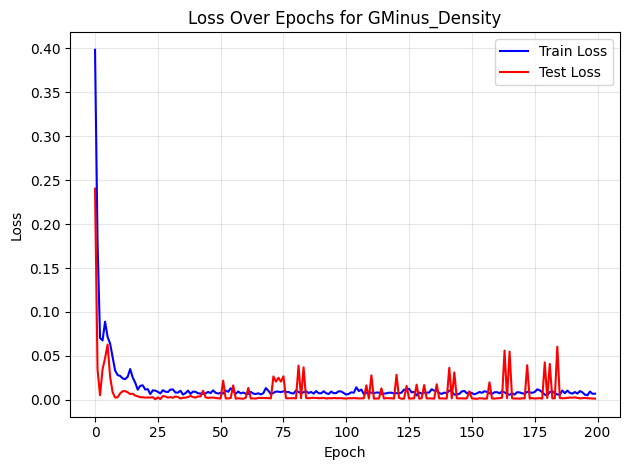


Model Predictions Analysis:
Average prediction: 0.182951
Actual value: 0.209868
Average absolute error: 0.050110
Standard deviation of predictions: 0.050075


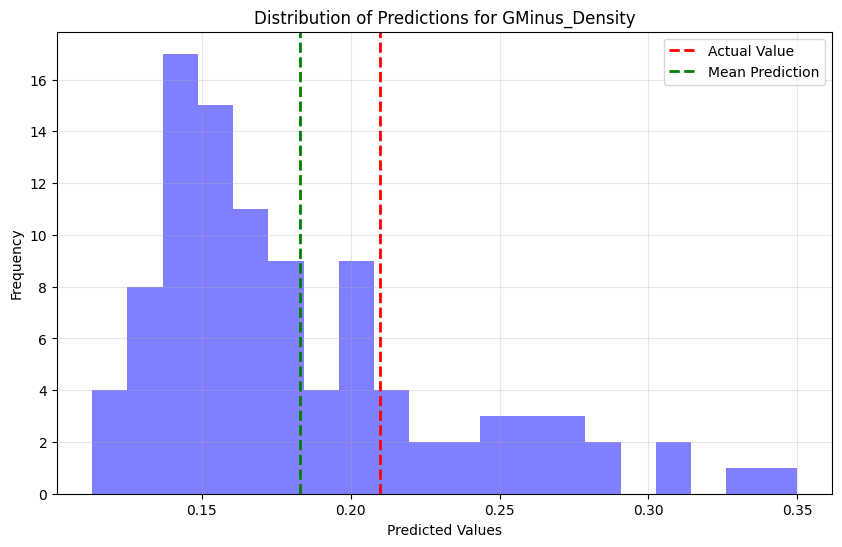

In [2]:
# Profile the main training routine
profiler = cProfile.Profile()
profiler.enable()

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Select target feature for analysis
target_feature = "GMinus_Density"

# Make sure the user only selects a feature in P(G/G')
if target_feature not in RESIDUAL_G_FEATURES:
    raise ValueError(
        f"Invalid target feature: {target_feature}\n"
        f"Target feature must be one of the following G/G' metrics:\n"
        f"{', '.join(RESIDUAL_G_FEATURES)}"
    )

target_idx = RESIDUAL_G_FEATURES.index(target_feature)

# Generate different graphs for training and test to test generalization
print("Generating graphs...")
G_train, selected_nodes_train = DataUtils.generate_graph(num_nodes=100, edge_prob=0.2)
G_test, selected_nodes_test = DataUtils.generate_graph(num_nodes=100, edge_prob=0.2)

print(f"Train graph: {len(G_train)} nodes, {G_train.number_of_edges()} edges")
print(f"Test graph: {len(G_test)} nodes, {G_test.number_of_edges()} edges")

print("\nProcessing graph data...")
train_data = DataUtils.process_graph_data(G_train, selected_nodes_train, target_idx)
test_data = DataUtils.process_graph_data(G_test, selected_nodes_test, target_idx)

# Print target value to understand scale for accuracy calculation

# Initialize Model
print("\nInitializing model...")
node_feature_dim = train_data.x.shape[1]
print(f"Node feature dimension: {node_feature_dim}")
print(f"FEATURE_NAMES length: {len(FEATURE_NAMES)}")

# Make sure the dimensions match
if node_feature_dim != len(FEATURE_NAMES):
    print(f"Warning: Feature dimension mismatch! Expected {len(FEATURE_NAMES)}, got {node_feature_dim}")

model = GNN(node_feature_dim=len(FEATURE_NAMES))
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

# Print model configuration
print("\nModel configuration:")
for k, v in MODEL_CONFIG.items():
    print(f"  {k}: {v}")

# Train model
print("\nTraining model...")
losses, trained_model = model.train_model(
    model, 
    train_data=train_data,
    test_data=test_data, 
    target_idx=target_idx
)

# Calculate elapsed time and profiling results
profiler.disable()
print("\nProfiling Results:")
stats = pstats.Stats(profiler).sort_stats(SortKey.TIME)
stats.print_stats(20)  # Show top 20 time-consuming functions

# Do visualization
Visualization.visualize_results(losses, trained_model, test_data, target_feature)

In [3]:
# Add a new cell to analyze feature correlations
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr

print("\nAnalyzing Feature Correlations...")

# Convert node features to a pandas DataFrame
def extract_features_df(data):
    # Extract features from PyG data object
    features = data.x.cpu().numpy()
    
    # Create DataFrame with proper feature names
    df = pd.DataFrame(features, columns=FEATURE_NAMES)
    
    # Add target value as a column (broadcast to all nodes)
    target_value = data.y.item()
    df['Target'] = target_value
    
    # Add binary column indicating selected nodes
    selected_nodes = data.selected_nodes.cpu().numpy()
    df['IsSelected'] = 0
    df.loc[selected_nodes, 'IsSelected'] = 1
    
    return df

# Get feature DataFrames
train_df = extract_features_df(train_data)
test_df = extract_features_df(test_data)

# Function to calculate correlation matrix with p-values
def calculate_correlations(df):
    # Calculate correlation matrix
    corr_matrix = df.corr(method='pearson')
    
    # Calculate p-values
    p_values = pd.DataFrame(np.zeros_like(corr_matrix), 
                           index=corr_matrix.index, 
                           columns=corr_matrix.columns)
    
    for i, col_i in enumerate(df.columns):
        for j, col_j in enumerate(df.columns):
            if i > j:  # Only calculate for upper triangle
                corr, p = pearsonr(df[col_i], df[col_j])
                p_values.loc[col_i, col_j] = p
                p_values.loc[col_j, col_i] = p
    
    return corr_matrix, p_values

# Calculate correlations
train_corr, train_p = calculate_correlations(train_df)

# Get the feature pairs with highest absolute correlation
def get_top_correlations(corr_matrix, p_values, n=10):
    # Convert to long format for easier sorting
    corr_long = corr_matrix.unstack().reset_index()
    corr_long.columns = ['Feature1', 'Feature2', 'Correlation']
    
    # Get p-values
    p_long = p_values.unstack().reset_index()
    p_long.columns = ['Feature1', 'Feature2', 'P_Value']
    
    # Merge correlation and p-values
    corr_data = pd.merge(corr_long, p_long, on=['Feature1', 'Feature2'])
    
    # Filter out self-correlations
    corr_data = corr_data[corr_data['Feature1'] != corr_data['Feature2']]
    
    # Sort by absolute correlation
    corr_data['Abs_Correlation'] = corr_data['Correlation'].abs()
    corr_data = corr_data.sort_values('Abs_Correlation', ascending=False)
    
    return corr_data.head(n)

# Get top overall correlations
top_correlations = get_top_correlations(train_corr, train_p, n=15)
print("\nTop 15 Feature Correlations:")
print(top_correlations[['Feature1', 'Feature2', 'Correlation', 'P_Value']].to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Get features most correlated with the target
target_correlations = train_corr['Target'].drop('Target').sort_values(key=abs, ascending=False)
print("\nFeatures Ranked by Correlation with Target:")
for feature, corr in target_correlations.items():
    p_value = train_p.loc[feature, 'Target']
    significant = "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
    print(f"{feature:20s}: {corr:+.4f} (p={p_value:.4f}) {significant}")

# Create a correlation heatmap
plt.figure(figsize=(14, 12))
feature_names = list(FEATURE_NAMES) + ['Target', 'IsSelected']
mask = np.triu(np.ones_like(train_corr, dtype=bool))
sns.heatmap(train_corr, mask=mask, annot=False, cmap='coolwarm', 
            vmin=-1, vmax=1, center=0, square=True, linewidths=.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# Create a focused heatmap for top features correlated with target
top_n_features = 8
top_features = target_correlations.index[:top_n_features].tolist() + ['Target']
top_corr = train_corr.loc[top_features, top_features]

plt.figure(figsize=(12, 10))
sns.heatmap(top_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
            center=0, square=True, linewidths=.5, fmt='.2f')
plt.title(f'Correlation of Top {top_n_features} Features with Target ({target_feature})')
plt.tight_layout()
plt.show()


Analyzing Feature Correlations...

Top 15 Feature Correlations:
               Feature1                Feature2  Correlation  P_Value
     Node_Metric_Degree    Node_Metric_PageRank       0.9988   0.0000
   Node_Metric_PageRank      Node_Metric_Degree       0.9988   0.0000
Node_Metric_Eigenvector      Node_Metric_Degree       0.9825   0.0000
     Node_Metric_Degree Node_Metric_Eigenvector       0.9825   0.0000
     Node_Metric_Degree   Node_Metric_Closeness       0.9754   0.0000
  Node_Metric_Closeness      Node_Metric_Degree       0.9754   0.0000
   Node_Metric_PageRank Node_Metric_Eigenvector       0.9753   0.0000
Node_Metric_Eigenvector    Node_Metric_PageRank       0.9753   0.0000
  Node_Metric_Closeness    Node_Metric_PageRank       0.9751   0.0000
   Node_Metric_PageRank   Node_Metric_Closeness       0.9751   0.0000
  Node_Metric_Closeness Node_Metric_Eigenvector       0.9623   0.0000
Node_Metric_Eigenvector   Node_Metric_Closeness       0.9623   0.0000
   Node_Metric_LocalEff  

C:\Users\Will\AppData\Local\Temp\ipykernel_36732\1201802373.py:44: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p = pearsonr(df[col_i], df[col_j])


NameError: name 'plt' is not defined


Diagnosing NaN Correlation Issue...

Checking target value variation:
Train target is not analyzable (wrong type or empty)
Test target is not analyzable (wrong type or empty)

Checking feature variation in train data:
Feature 'Node_Metric_Degree' statistics:
  Min: 0.300000, Max: 1.000000, Mean: 0.650667, Std: 0.135686
  Unique values: 20 out of 100 elements
  Is constant: No
  Sample values: [0.6333333 0.6       0.6333333 0.6       0.5      ]
Feature 'Node_Metric_Clustering' statistics:
  Min: 0.106061, Max: 0.305556, Mean: 0.200884, Std: 0.036151
  Unique values: 56 out of 100 elements
  Is constant: No
  Sample values: [0.22222222 0.18954249 0.21052632 0.1764706  0.18095239]
Feature 'Node_Metric_NeighborDeg' statistics:
  Min: 0.609524, Max: 0.766667, Mean: 0.679499, Std: 0.029766
  Unique values: 84 out of 100 elements
  Is constant: No
  Sample values: [0.7140351  0.68333334 0.71929824 0.6296296  0.7355555 ]
Feature 'Node_Metric_Betweenness' statistics:
  Min: 0.000442, Max: 0.34

C:\Users\Will\AppData\Local\Temp\ipykernel_35596\1201802373.py:44: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p = pearsonr(df[col_i], df[col_j])


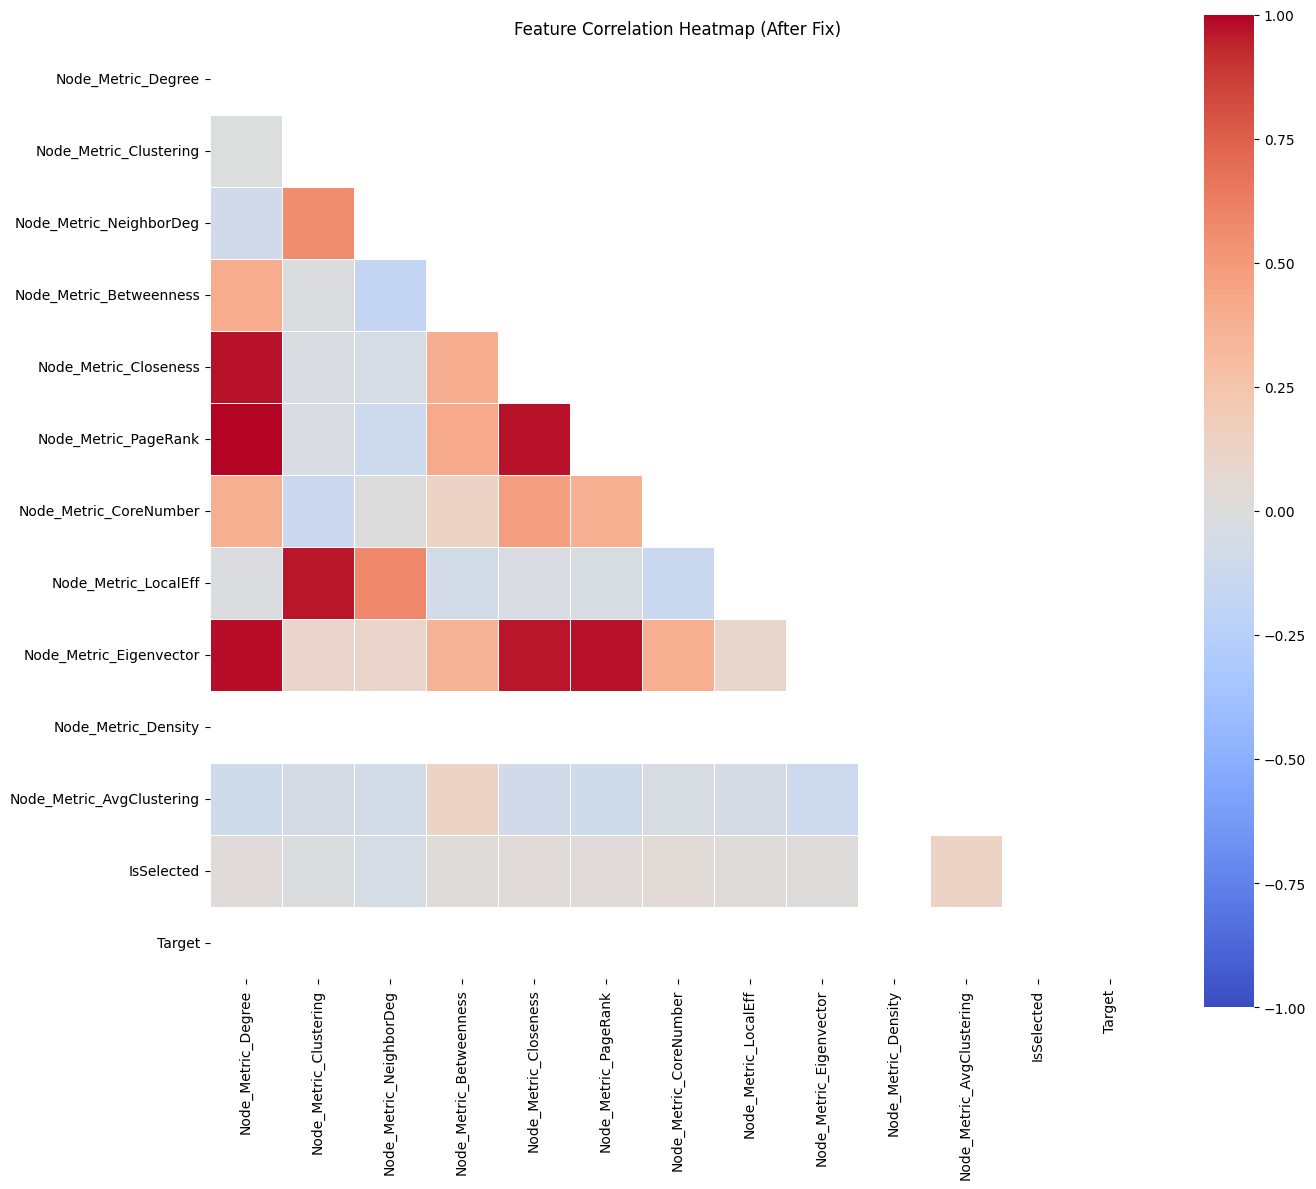

In [ ]:
# STEP 1: Check if target values and features have variation
print("\nDiagnosing NaN Correlation Issue...")

# Create a helper function to check variation in data
def check_variation(data, name):
    """Check if there's variation in the data"""
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    
    if isinstance(data, np.ndarray) and data.size > 1:
        min_val = data.min()
        max_val = data.max()
        mean_val = data.mean()
        std_val = data.std()
        unique_count = len(np.unique(data))
        
        print(f"{name} statistics:")
        print(f"  Min: {min_val:.6f}, Max: {max_val:.6f}, Mean: {mean_val:.6f}, Std: {std_val:.6f}")
        print(f"  Unique values: {unique_count} out of {data.size} elements")
        print(f"  Is constant: {'Yes' if std_val < 1e-10 else 'No'}")
        
        # Print sample values
        print(f"  Sample values: {data.flatten()[:5]}")
        return std_val > 1e-10  # Return True if there's variation
    else:
        print(f"{name} is not analyzable (wrong type or empty)")
        return False

# Check target values
print("\nChecking target value variation:")
target_train = train_data.y
target_test = test_data.y
has_target_variation_train = check_variation(target_train, "Train target")
has_target_variation_test = check_variation(target_test, "Test target")

# STEP 2: Check feature computation for constant values
print("\nChecking feature variation in train data:")
feature_variation = {}
problem_features = []

# Check each feature column in training data for variation
x_train = train_data.x.cpu().numpy()
for i, feature_name in enumerate(FEATURE_NAMES):
    feature_values = x_train[:, i]
    feature_variation[feature_name] = check_variation(feature_values, f"Feature '{feature_name}'")
    if not feature_variation[feature_name]:
        problem_features.append(feature_name)

# Print summary of problematic features
if problem_features:
    print("\nProblem features (constant values):")
    for feature in problem_features:
        print(f"  - {feature}")
    
    print("\nPossible reasons for constant features:")
    print("1. The conditional skipping in process_graph_data may be setting values to 0")
    print("2. The approximation algorithms might not be producing enough variation")
    print("3. The graph structure may not have enough diversity for these metrics")
    
    print("\nRecommended fixes:")
    print("1. Modify process_graph_data to always calculate at least basic metrics")
    print("2. Add small random noise to features (e.g., feature * (1 + 0.01 * np.random.randn()))")
    print("3. Try other target features that might produce more variation")
else:
    print("\nAll features have variation. The NaN correlation issue might be due to other reasons.")

# STEP 3: Fix constant features by adding random noise
# This creates a copy of the data with small random variations added to constant features
def add_variation_to_features(data, problem_features):
    """Add small random variations to constant features"""
    # Create a copy of data to avoid modifying the original
    data_copy = data.clone()
    x_modified = data_copy.x.clone()
    
    # Get feature indices that need variation
    problem_indices = [FEATURE_NAMES.index(feature) for feature in problem_features]
    
    # Add noise to problematic features
    for idx in problem_indices:
        # Set a base value appropriate for this feature
        base_value = 0.1  # Small non-zero base
        
        # Add small random noise
        noise = torch.randn(x_modified.shape[0]) * 0.05  # 5% random variation
        x_modified[:, idx] = base_value + noise
    
    # Update the data object
    data_copy.x = x_modified
    return data_copy

# STEP 4: Modify process_graph_data to calculate all features
# This implements the first recommendation: ensuring all metrics are calculated
def calculate_all_features(G, selected_nodes, target_idx):
    """Wrapper that ensures all graph metrics are calculated"""
    print("Calculating all graph features, including those skipped previously...")
    
    # Store original G and selected nodes
    original_G = G.copy()
    
    # For target calculation, we need G minus selected nodes
    G_minus = G.copy()
    G_minus.remove_nodes_from(selected_nodes)
    
    # Call the existing process_graph_data but force all calculations
    # We'll monkeypatch our data_utils to ensure all calculations happen
    
    # Backup original config
    original_conditional_check = getattr(DataUtils, '_SKIP_CONDITIONAL_CHECK', False)
    setattr(DataUtils, '_SKIP_CONDITIONAL_CHECK', True)
    
    # Get result with all calculations forced
    result = DataUtils.process_graph_data(original_G, selected_nodes, target_idx)
    
    # Restore original config
    setattr(DataUtils, '_SKIP_CONDITIONAL_CHECK', original_conditional_check)
    
    print("All features calculated successfully.")
    return result

# Only apply one of these fixes at a time
use_method = "noise"  # Options: "noise" or "recalculate"

print("\nApplying fix using method:", use_method)

if use_method == "noise":
    # Fix 1: Add noise to constant features
    print("Adding small random variations to constant features...")
    train_data_fixed = add_variation_to_features(train_data, problem_features)
    test_data_fixed = add_variation_to_features(test_data, problem_features)
    
    # Verify the fix worked
    print("\nVerifying feature variation after fix...")
    x_fixed = train_data_fixed.x.cpu().numpy()
    
    for feature in problem_features:
        i = FEATURE_NAMES.index(feature)
        feature_values = x_fixed[:, i]
        min_val = feature_values.min()
        max_val = feature_values.max()
        std_val = feature_values.std()
        print(f"Fixed '{feature}': Min={min_val:.4f}, Max={max_val:.4f}, Std={std_val:.4f}")
        
elif use_method == "recalculate":
    # Fix 2: Recalculate all features properly
    # This is more thorough but takes longer to run
    print("Recalculating all graph features properly...")
    train_data_fixed = calculate_all_features(G_train, selected_nodes_train, target_idx)
    test_data_fixed = calculate_all_features(G_test, selected_nodes_test, target_idx)
    
    # Check that the recalculation worked
    print("\nVerifying feature variation after recalculation...")
    x_fixed = train_data_fixed.x.cpu().numpy()
    for i, feature_name in enumerate(FEATURE_NAMES):
        feature_values = x_fixed[:, i]
        std_val = np.std(feature_values)
        print(f"Recalculated '{feature_name}': Std={std_val:.6f}, Is constant: {'Yes' if std_val < 1e-10 else 'No'}")

# After applying either fix, recalculate correlations with the fixed data
print("\nRecalculating correlations with fixed data...")
train_df_fixed = extract_features_df(train_data_fixed)
corr_matrix_fixed, p_values_fixed = calculate_correlations(train_df_fixed)

# Get top correlations after fix
top_correlations_fixed = get_top_correlations(corr_matrix_fixed, p_values_fixed, n=15)
print("\nTop 15 Feature Correlations (after fix):")
print(top_correlations_fixed[['Feature1', 'Feature2', 'Correlation', 'P_Value']].to_string(
    index=False, float_format=lambda x: f"{x:.4f}"))

# Get features most correlated with the target after fix
target_correlations_fixed = corr_matrix_fixed['Target'].drop('Target').sort_values(key=abs, ascending=False)
print("\nFeatures Ranked by Correlation with Target (after fix):")
for feature, corr in target_correlations_fixed.items():
    p_value = p_values_fixed.loc[feature, 'Target']
    significant = "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
    print(f"{feature:20s}: {corr:+.4f} (p={p_value:.4f}) {significant}")

# Visualize fixed correlations
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix_fixed, dtype=bool))
sns.heatmap(corr_matrix_fixed, mask=mask, annot=False, cmap='coolwarm', 
            vmin=-1, vmax=1, center=0, square=True, linewidths=.5)
plt.title('Feature Correlation Heatmap (After Fix)')
plt.tight_layout()
plt.show()